In [42]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from scipy.stats import *
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # informative statistical graphics.
import statsmodels.api as sm #for ARIMA and SARIMAX
import datetime
from datetime import timedelta


sns.set_style('darkgrid') #set color style for plot

In [43]:
#importing dataset for API

train = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')

#DF = DF[:-1]
# train = train[:-1]

train['Date'] = pd.to_datetime(train['Date'], format="%d-%b-%y")

train.tail()

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
1786,2021-10-30,2021-10-30,Recovered,14672,1,535,10,371,2,2,...,27,1,3,1172,191,8,9,6,880,0
1787,2021-10-30,2021-10-30,Deceased,445,0,2,0,4,0,0,...,1,0,0,14,1,0,0,0,13,0
1788,2021-10-31,2021-10-31,Confirmed,12907,0,385,1,212,8,5,...,26,2,21,1009,121,12,6,5,914,0
1789,2021-10-31,2021-10-31,Recovered,13152,0,675,9,236,9,3,...,25,2,8,1183,183,2,6,9,913,0
1790,2021-10-31,2021-10-31,Deceased,251,0,4,0,1,0,0,...,1,0,1,19,1,0,0,0,15,0


In [44]:
#Since we are predicting total cases ('TT') column we don't need state data ,  hence droping out state data

cols = ['AN','AP',	'AR',	'AS',	'BR',	'CH',	'CT',	'DD',	'DL',	'DN',	'GA',	'GJ',	'HP',	'HR',	'JH', 'JK',	'KA',	'KL',	'LA',	'LD',	'MH',	'ML',	'MN',	'MP',	'MZ',	'NL',	'OR',	'PB',	'PY',	'RJ',	'SK',	'TG',	'TN',	'TR',	'UP',	'UT',	'WB']
train.drop(cols, axis=1, inplace=True)
train = train.set_index('Status')
train.drop(['Recovered','Deceased'],inplace=True)
train = train.reset_index()
train.drop(["Status"],axis=1,inplace= True)

In [45]:
train.tail()

,Date,Date_YMD,TT,UN
592,2021-10-27,2021-10-27,16351,0
593,2021-10-28,2021-10-28,14307,0
594,2021-10-29,2021-10-29,14215,0
595,2021-10-30,2021-10-30,12940,0
596,2021-10-31,2021-10-31,12907,0


In [46]:
# # copying data into train_df Dataframe so that our orignal data is untouched 

train_df = train

train_df.head()

,Date,Date_YMD,TT,UN
0,2020-03-14,2020-03-14,81,0
1,2020-03-15,2020-03-15,27,0
2,2020-03-16,2020-03-16,15,0
3,2020-03-17,2020-03-17,11,0
4,2020-03-18,2020-03-18,37,0


<AxesSubplot:xlabel='Date', ylabel='TT'>

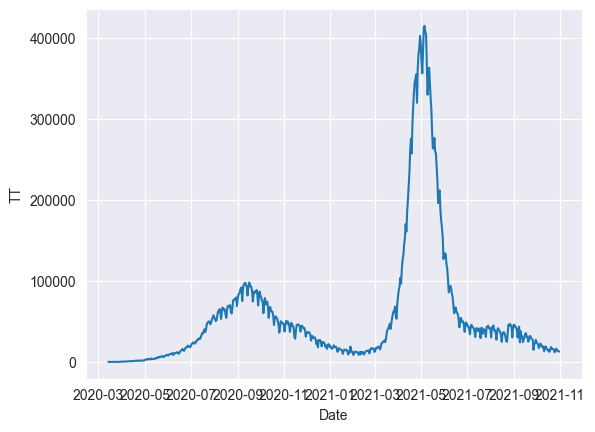

In [47]:
#plotting current data

sns.lineplot(x="Date", y="TT",legend = 'full' , data=train_df)

In [48]:
#setting 'date' column as index columna as forecasting will be done for this column
#making 'TT' as float for statistical calculations

train_df = train_df.set_index('Date')
train_df['TT'] = train_df['TT'].astype(float)

train_df.head()

,Date_YMD,TT,UN
Date,,,
2020-03-14,2020-03-14,81.0,0
2020-03-15,2020-03-15,27.0,0
2020-03-16,2020-03-16,15.0,0
2020-03-17,2020-03-17,11.0,0
2020-03-18,2020-03-18,37.0,0


<Figure size 640x480 with 0 Axes>

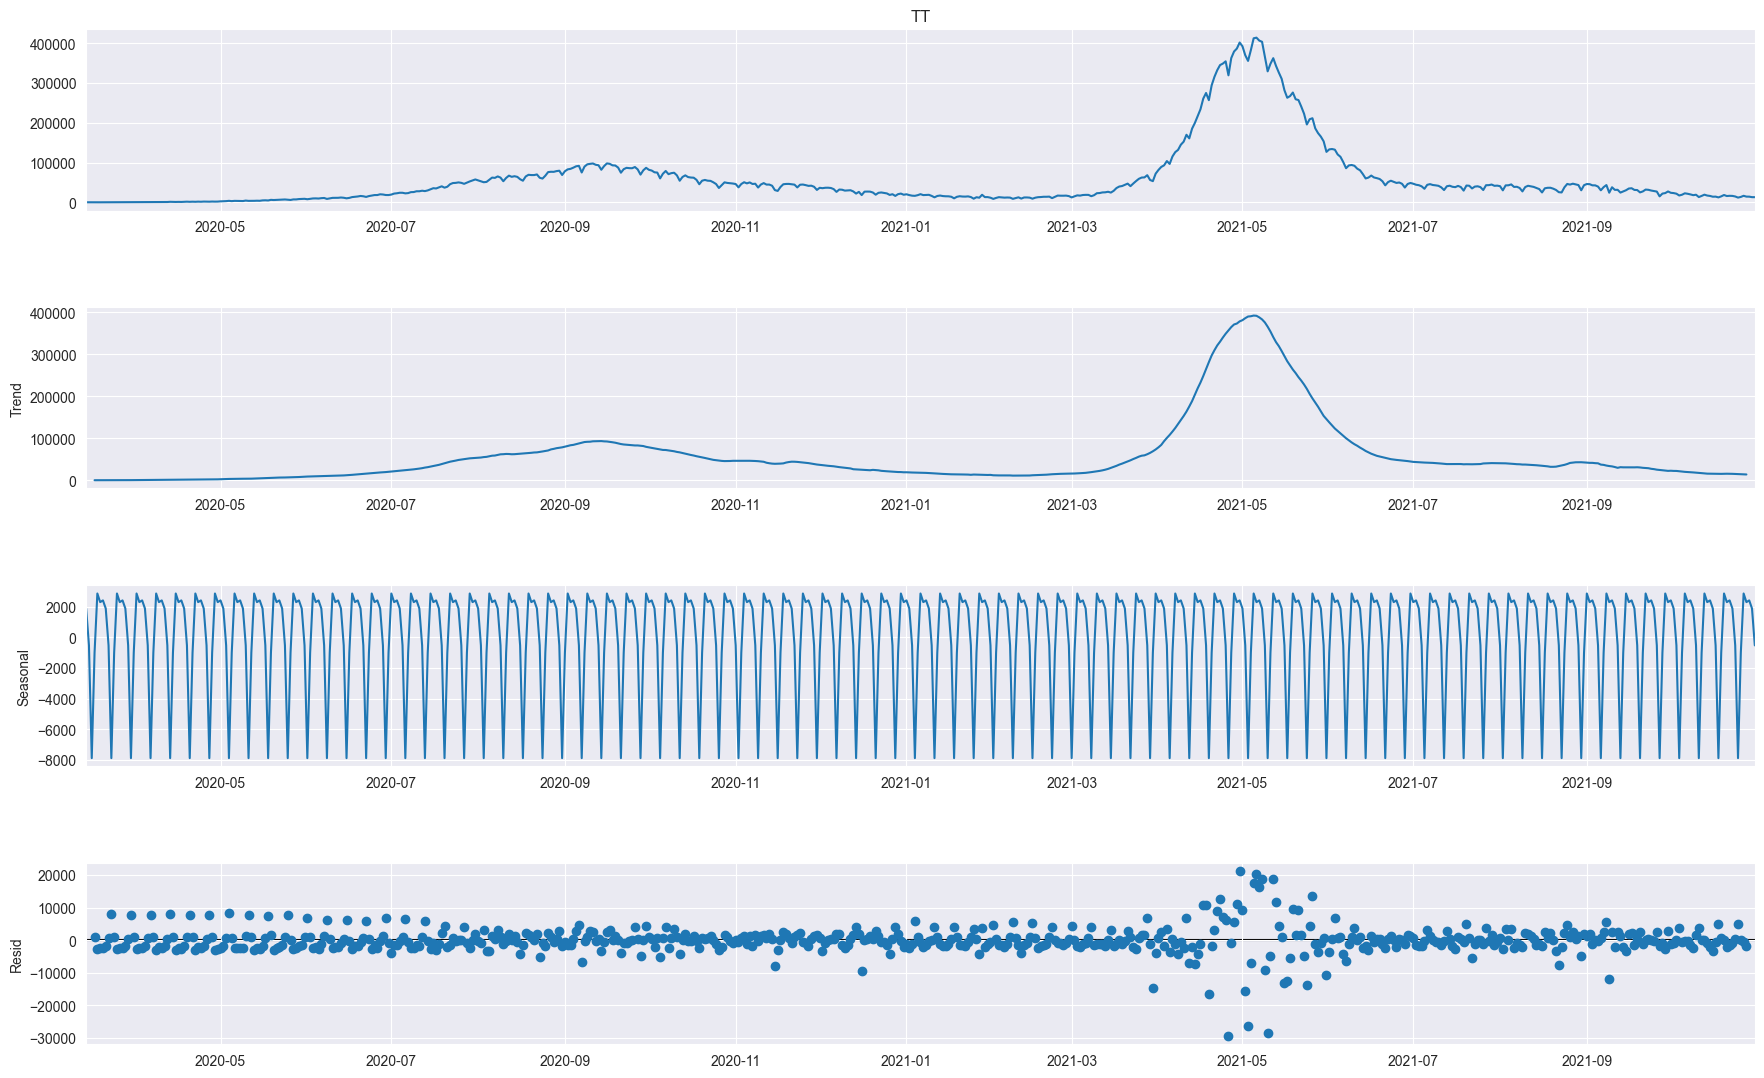

In [49]:
#Decomposing data to observe if there exists a sesional trend

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['TT'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

The 'trend' graph has a upward growth which shows that the data is not stationary. Time Series forecasting can be done on stationary data and hence we need to nake it stationary.

In [50]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The samaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

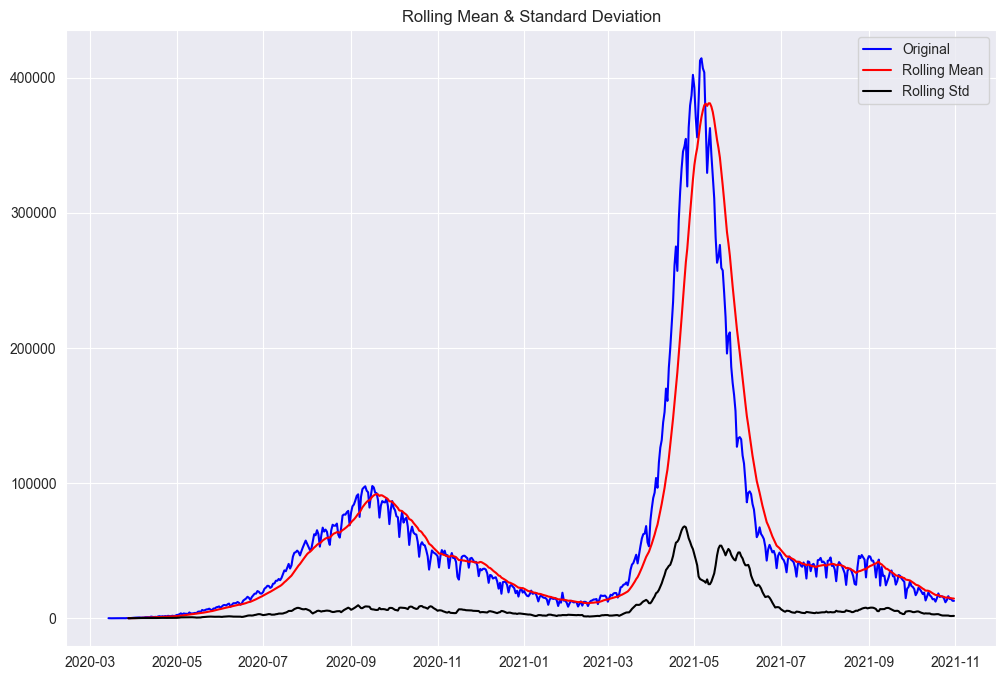

Results of Dickey-Fuller Test:
p-value = 0.0201. The series is likely non-stationary.
Test Statistic                  -3.198105
p-value                          0.020095
#Lags Used                      19.000000
Number of Observations Used    577.000000
Critical Value (1%)             -3.441734
Critical Value (5%)             -2.866562
Critical Value (10%)            -2.569445
dtype: float64


In [51]:
test_stationarity(train_df['TT'])

#calling the function gives below result , where we can observe the huge gap between orignal data and mean,std
#also the pvalue is 0.9778 which is not so good and hence , the output says "The series is likely non-stationary."

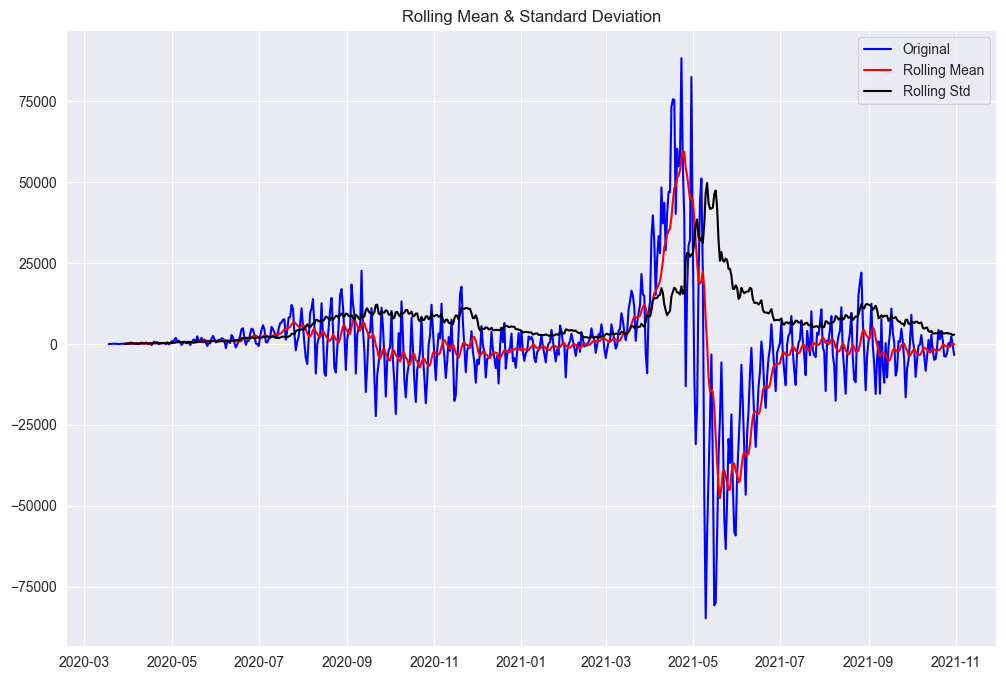

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.240639e+00
p-value                        4.706636e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.730000e+02
Critical Value (1%)           -3.441814e+00
Critical Value (5%)           -2.866597e+00
Critical Value (10%)          -2.569463e+00
dtype: float64


In [52]:
#here are various methods for making series stationary like log, differencing and so on..
#here we are using differencing , shift operator shifts the 'TT' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.3427 which is quite good as compared to our previous value 0.9778
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = train_df.TT - train_df.TT.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

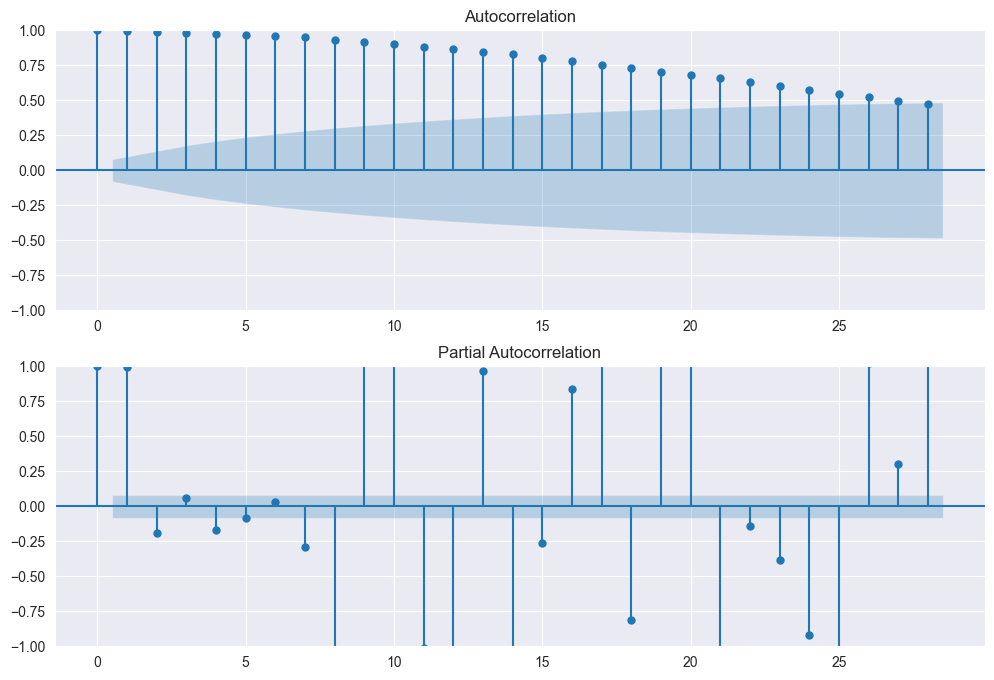

In [53]:
#plotting autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.TT, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.TT, ax=ax2) # using default value of lag

Here in partial autocorrelation we can see a small upward trend for ( almost ) every second plot as compared to previous plot. 

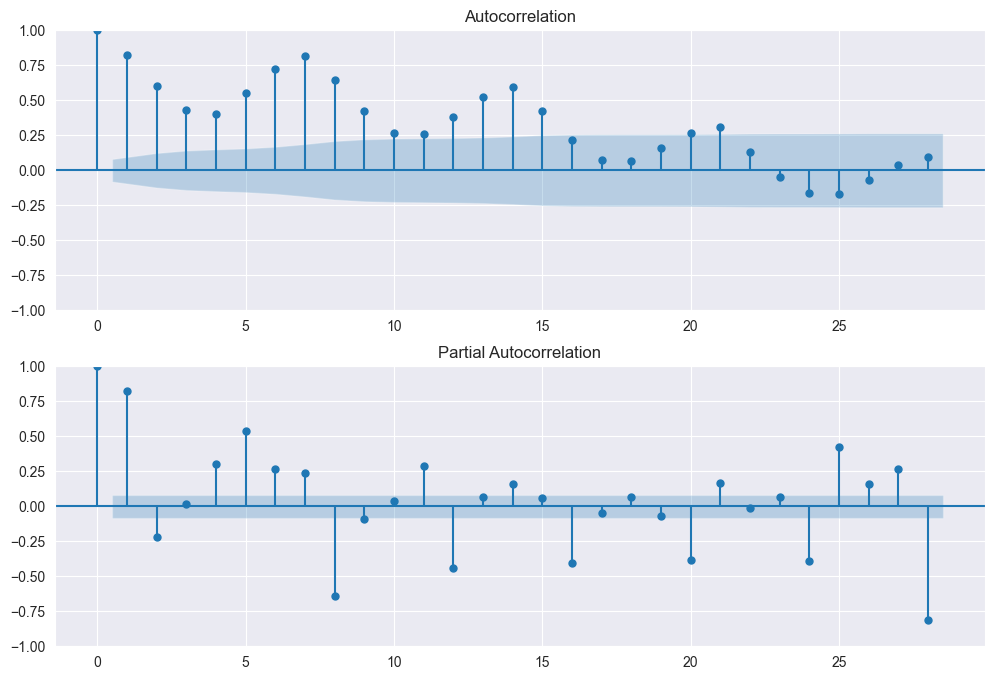

In [54]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)

In [55]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(train_df.TT, trend='n', order=(14,1,0)).fit()
print(sarimax_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                     TT   No. Observations:                  597
Model:              SARIMAX(14, 1, 0)   Log Likelihood               -5840.113
Date:                Tue, 20 Dec 2022   AIC                          11710.226
Time:                        01:35:38   BIC                          11776.079
Sample:                    03-14-2020   HQIC                         11735.869
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0979      0.027     -3.625      0.000      -0.151      -0.045
ar.L2          0.0975      0.027      3.675      0.000       0.045       0.149
ar.L3          0.1132      0.024      4.741      0.0

NormaltestResult(statistic=133.74209269238713, pvalue=9.083925687592661e-30)


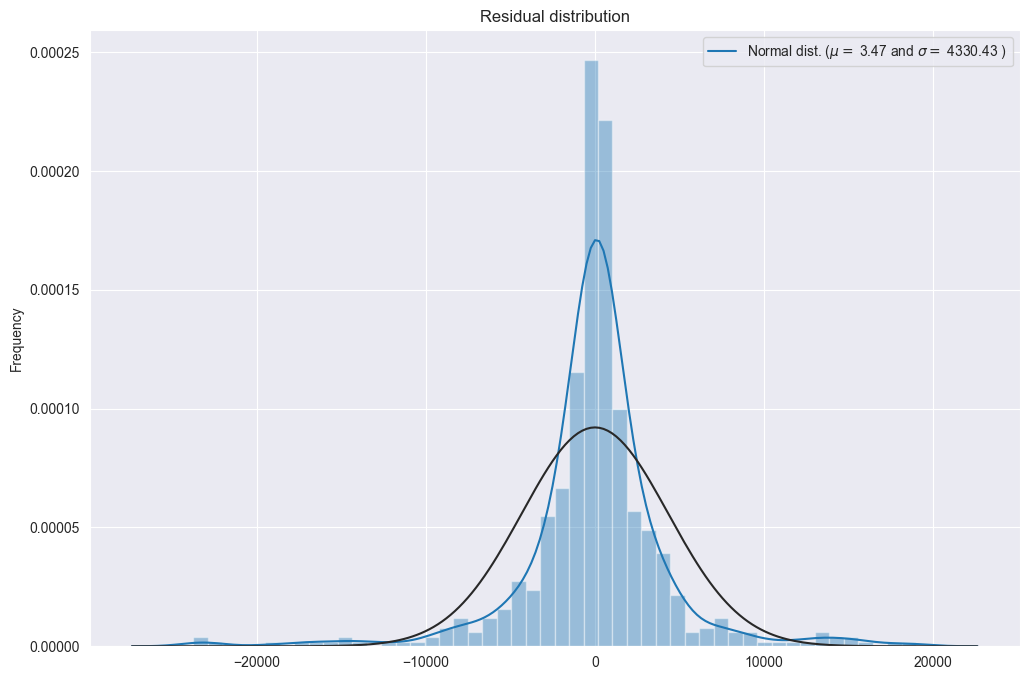

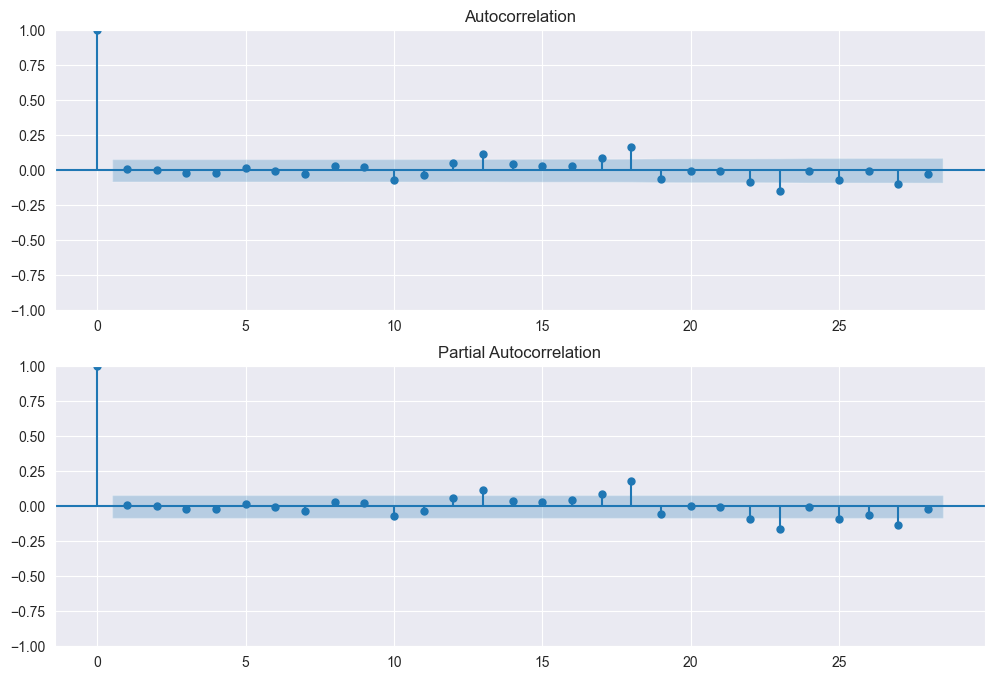

In [56]:
import scipy.stats as stats

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

<AxesSubplot:xlabel='Date'>

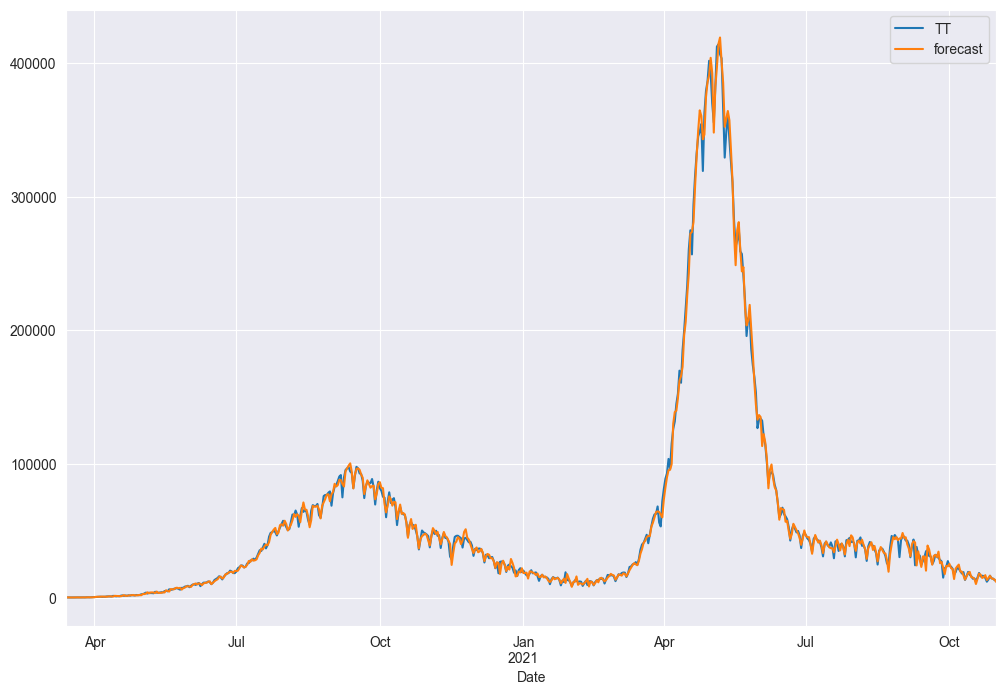

In [57]:
#Now lets predict using out model.
today = datetime.date.today() -timedelta(days=1)

start_index = '14-Mar-20'
end_index = today.strftime("%Y-%m-%d")

#adding forecasted values and plotting
train_df['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,)  

train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

In [100]:
#lets predict for upcomming dates ..



future_predict = sarimax_mod.predict(start= datetime.date(2021,11,1) ,end = datetime.date(2021,11,1)+timedelta(days=30) ,dynamic= True,)

In [101]:
future_predict

2021-11-01    10335.989889
2021-11-02    12172.166268
2021-11-03    14614.993070
2021-11-04    12738.611445
2021-11-05    12546.283733
2021-11-06    12071.937423
2021-11-07    11607.168079
2021-11-08     9698.191036
2021-11-09    11379.642843
2021-11-10    13491.591698
2021-11-11    12023.157844
2021-11-12    11681.414325
2021-11-13    11341.931678
2021-11-14    10966.767754
2021-11-15     9347.345473
2021-11-16    10988.329420
2021-11-17    12815.979201
2021-11-18    11513.065254
2021-11-19    11100.537284
2021-11-20    10949.207790
2021-11-21    10531.622677
2021-11-22     9239.546350
2021-11-23    10753.595138
2021-11-24    12326.279386
2021-11-25    11189.939543
2021-11-26    10723.919823
2021-11-27    10681.305181
2021-11-28    10279.205448
2021-11-29     9217.081669
2021-11-30    10626.162393
2021-12-01    11979.646858
Freq: D, Name: predicted_mean, dtype: float64

In [102]:
# train_df=train_df.reset_index()
# train_df.head()

In [103]:
# dates=[]
# for i in future_predict.index:
#     if type(i)==type(future_predict.index[0]):
#       dates.append(i)
# data=[]
# for i in future_predict.values:
#   if type(i)==type(future_predict.values[0]):
#     data.append(i)

In [104]:
# train_df=train_df.reset_index()
# DF=pd.DataFrame({'forecast':data,'date':dates})
# train_df=train_df.append(DF)
# train_df=train_df.reset_index()
# train_df = train_df.set_index('date')
# train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

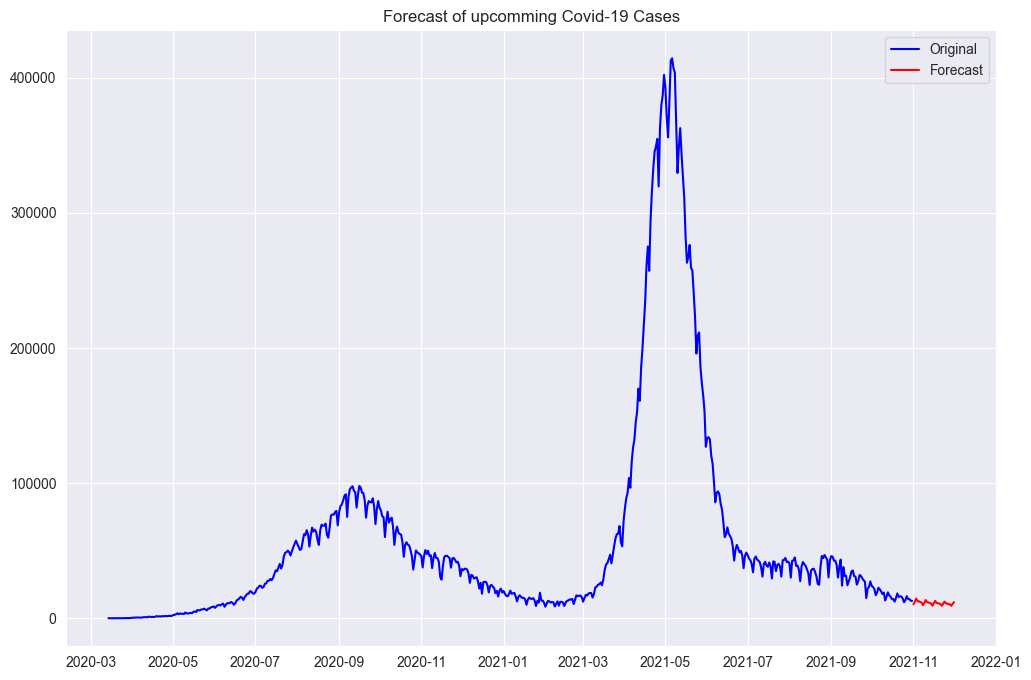

In [105]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()

In [106]:
f_temp = pd.DataFrame()

In [107]:
f_temp['date'] = future_predict.index
f_temp['values'] = future_predict.values

In [108]:
f_temp

,date,values
0,2021-11-01,10335.989889
1,2021-11-02,12172.166268
2,2021-11-03,14614.993070
3,2021-11-04,12738.611445
4,2021-11-05,12546.283733
5,2021-11-06,12071.937423
6,2021-11-07,11607.168079
7,2021-11-08,9698.191036
8,2021-11-09,11379.642843
9,2021-11-10,13491.591698


In [109]:
f_temp.loc[-1] = [train_df.index[-1],train_df['TT'][-1]]

In [110]:
f_temp

,date,values
0,2021-11-01,10335.989889
1,2021-11-02,12172.166268
2,2021-11-03,14614.993070
3,2021-11-04,12738.611445
4,2021-11-05,12546.283733
5,2021-11-06,12071.937423
6,2021-11-07,11607.168079
7,2021-11-08,9698.191036
8,2021-11-09,11379.642843
9,2021-11-10,13491.591698


In [111]:
f_temp.index = f_temp.index + 1

In [112]:
#f_temp = f_temp.sort_index()
f_temp

,date,values
1,2021-11-01,10335.989889
2,2021-11-02,12172.166268
3,2021-11-03,14614.993070
4,2021-11-04,12738.611445
5,2021-11-05,12546.283733
6,2021-11-06,12071.937423
7,2021-11-07,11607.168079
8,2021-11-08,9698.191036
9,2021-11-09,11379.642843
10,2021-11-10,13491.591698


In [113]:
# f_temp.drop(1,inplace=True)
f_temp = f_temp.sort_index()
f_temp

,date,values
0,2021-10-31,12907.000000
1,2021-11-01,10335.989889
2,2021-11-02,12172.166268
3,2021-11-03,14614.993070
4,2021-11-04,12738.611445
5,2021-11-05,12546.283733
6,2021-11-06,12071.937423
7,2021-11-07,11607.168079
8,2021-11-08,9698.191036
9,2021-11-09,11379.642843


In [114]:
f_temp['date'] = pd.to_datetime(f_temp['date'], format="%d-%b-%y")
f_temp = f_temp.set_index('date')

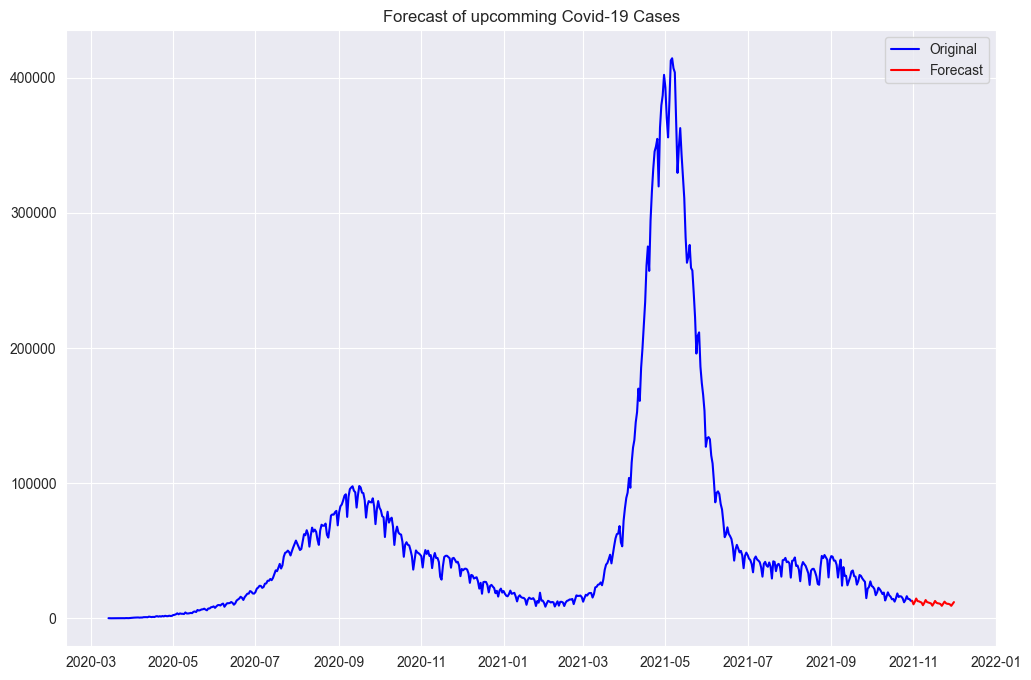

In [115]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()

In [119]:
fcast = sarimax_mod.get_forecast(datetime.date(2021,11,1)+timedelta(days=30))
fcast = fcast.conf_int()
fcast

#This will give us confidence levels for our predictions

,lower TT,upper TT
2021-11-01,1740.999113,18930.980664
2021-11-02,596.697694,23747.634842
2021-11-03,150.487842,29079.498299
2021-11-04,-4552.854003,30030.076893
2021-11-05,-7484.825262,32577.392727
2021-11-06,-10950.322547,35094.197393
2021-11-07,-14907.567530,38121.903689
2021-11-08,-22765.213477,42161.595549
2021-11-09,-26275.164456,49034.450141
2021-11-10,-28844.092639,55827.276036


In [120]:
fcast = fcast.reset_index()
fcast.loc[-1] = [train_df.index[-1],train_df['TT'][-1],train_df['TT'][-1]]
fcast.index = fcast.index + 1
fcast = fcast.sort_index()
fcast['index'] = pd.to_datetime(fcast['index'], format="%d-%b-%y")
fcast = fcast.set_index('index')
fcast

,lower TT,upper TT
index,,
2021-10-31,12907.000000,12907.000000
2021-11-01,1740.999113,18930.980664
2021-11-02,596.697694,23747.634842
2021-11-03,150.487842,29079.498299
2021-11-04,-4552.854003,30030.076893
2021-11-05,-7484.825262,32577.392727
2021-11-06,-10950.322547,35094.197393
2021-11-07,-14907.567530,38121.903689
2021-11-08,-22765.213477,42161.595549


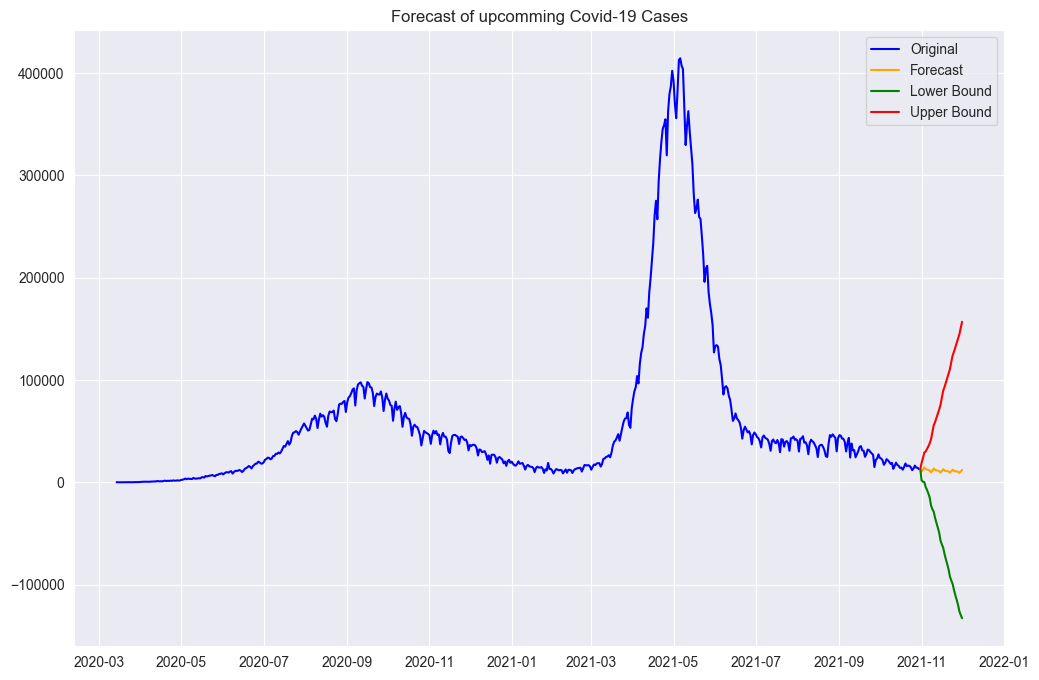

In [121]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='orange', label='Forecast')
lower = plt.plot(fcast['lower TT'], color='green', label='Lower Bound')
upper = plt.plot(fcast['upper TT'], color='red', label='Upper Bound')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()